# Forecasting Pipeline

A pipeline is a sequence of steps---often specific code and data structures---to achieve a goal. 
Our forecasting pipeline will input raw data, several sources on COVID-19 cases, thermometer data, influenza-like illness data, and output a dataset that contains probability distributions of the cumulative number of 1,2,3 and 4 week ahead COVID-19 cases for all XX counties in PA.

Our below example will build a forecasts for COVID-19 cases. 

# Step 1: Input retrospective data and team credentials

The data is stored on GitHub at "https://github.com/mcandrewlab/pasyndsurv".
We will **fork** and **clone** (copy) this github repository from the internet to our computer.
I cloned this repo on my computer in the following location

In [87]:
synSurvRepoFilename = "~/science/syndromicSurv" # the location of my github repo

Inside this GitHub repo you will create a folder for your team.
Pick a team name and create a folder inside the folder "/syndromicSurv/models/".

For example, suppose my team member and I decide to call our team "TheStatAttack".
I'll create a folder "/syndromicSurv/models/TheStatAttack"

### Building team files

In [88]:
trainingData = pd.read_csv("/Users/thomasmcandrew/science/syndromicSurv/data/cases/PATrainingDataCases.csv")
print(trainingData.head())

# look at the data we have available for a specific week
print(trainingData[trainingData.trainingweek==202020])

   Unnamed: 0  epiweek  modelweek region  fips  jhucsse__numnewpos  \
0        1173   201840       2543     pa   NaN                 NaN   
1        1173   201840       2543     pa   NaN                 NaN   
2        1174   201841       2544     pa   NaN                 NaN   
3        1173   201840       2543     pa   NaN                 NaN   
4        1174   201841       2544     pa   NaN                 NaN   

   covidtracker__numnewpos  covidtracker__numnewneg  covidtracker__numnewtest  \
0                      NaN                      NaN                       NaN   
1                      NaN                      NaN                       NaN   
2                      NaN                      NaN                       NaN   
3                      NaN                      NaN                       NaN   
4                      NaN                      NaN                       NaN   

   cdcili__num_patients  cdcili__num_providers  cdcili__wili  cdcili__ili  \
0              

# Step 2: Train model on retrospective data

In [89]:
from sklearn.linear_model import LinearRegression


testdata = trainingData[(trainingData.trainingweek==202020) & (trainingData.epiweek>201952)]
testdata = testdata.replace(np.nan,0)

mostRecentEW=testdata.epiweek.max()

specificRegion = testdata[testdata.fips==42069]

print(specificRegion)

       Unnamed: 0  epiweek  modelweek region     fips  jhucsse__numnewpos  \
11749          34   202004       2611     pa  42069.0                 0.0   
11818         103   202005       2612     pa  42069.0                 0.0   
11887         172   202006       2613     pa  42069.0                 0.0   
11954         241   202007       2614     pa  42069.0                 0.0   
12025         310   202008       2615     pa  42069.0                 0.0   
12092         379   202009       2616     pa  42069.0                 0.0   
12163         448   202010       2617     pa  42069.0                 0.0   
12232         517   202011       2618     pa  42069.0                 0.0   
12299         586   202012       2619     pa  42069.0                 5.0   
12370         655   202013       2620     pa  42069.0                46.0   
12438         724   202014       2621     pa  42069.0                95.0   
12508         793   202015       2622     pa  42069.0               246.0   

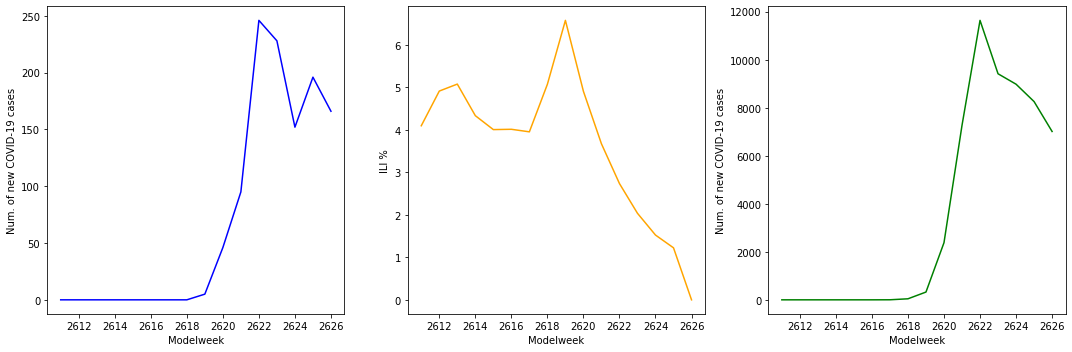

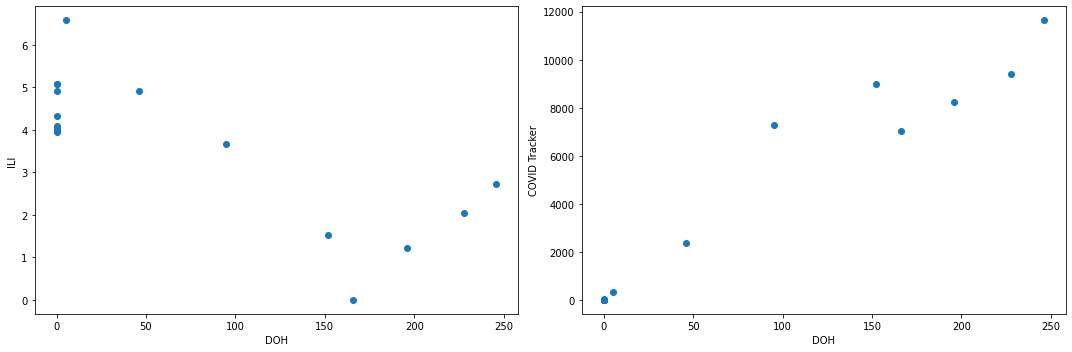

In [90]:
fig,axs = plt.subplots(1,3)

ax=axs[0]
ax.plot(specificRegion.modelweek, specificRegion.dohweb__numnewpos.values,color='blue')
ax.set_xlabel('Modelweek', fontsize=10)
ax.set_ylabel('Num. of new COVID-19 cases', fontsize=10)

ax=axs[1]
ax.plot(specificRegion.modelweek, specificRegion.cdcili__ili,color='orange')
ax.set_xlabel('Modelweek', fontsize=10)
ax.set_ylabel('ILI %', fontsize=10)

ax=axs[2]
ax.plot(specificRegion.modelweek, specificRegion.covidtracker__numnewpos,color='green')
ax.set_xlabel('Modelweek', fontsize=10)
ax.set_ylabel('Num. of new COVID-19 cases', fontsize=10)

fig.set_tight_layout(True)
fig.set_size_inches(15,5)


fig,axs = plt.subplots(1,2)

ax=axs[0]
ax.scatter( specificRegion.dohweb__numnewpos,specificRegion.cdcili__ili)
ax.set_xlabel('DOH', fontsize=10)
ax.set_ylabel('ILI', fontsize=10)


ax=axs[1]
ax.scatter( specificRegion.dohweb__numnewpos,specificRegion.covidtracker__numnewpos)
ax.set_xlabel('DOH', fontsize=10)
ax.set_ylabel('COVID Tracker', fontsize=10)

fig.set_tight_layout(True)
fig.set_size_inches(15,5)

### My Model

\begin{equation}
    \text{COVID cases}_{t} \sim \mathcal{N}\left( \beta_{0} +  \beta_{1} \text{ILI}_{t-1} +\beta_{2} \text{COVID Tracker}_{t-1}  , \sigma^{2} \right)
\end{equation}


In [91]:
covariates2predictCases = ['cdcili__ili','covidtracker__numnewpos']
target = ['dohweb__numnewpos']

Xvariables = specificRegion[['modelweek']+covariates2predictCases]
print(Xvariables)

Xvariables['modelweekPlusOne'] = Xvariables.modelweek+1
print(Xvariables.head())

Xvariables = Xvariables.drop(columns=['modelweek'])

targetVariable = specificRegion[ ['modelweek']+target]
print(targetVariable.head())


XandTarget = Xvariables.merge(targetVariable, left_on=['modelweekPlusOne'], right_on = ['modelweek'])
print(XandTarget)

       modelweek  cdcili__ili  covidtracker__numnewpos
11749       2611      4.09744                      0.0
11818       2612      4.91394                      0.0
11887       2613      5.07815                      0.0
11954       2614      4.33477                      0.0
12025       2615      4.00685                      0.0
12092       2616      4.01434                      0.0
12163       2617      3.95430                      2.0
12232       2618      5.07402                     43.0
12299       2619      6.57793                    324.0
12370       2620      4.90773                   2380.0
12438       2621      3.67279                   7266.0
12508       2622      2.73676                  11638.0
12577       2623      2.03678                   9414.0
12644       2624      1.52470                   8980.0
12715       2625      1.22405                   8256.0
12765       2626      0.00000                   7011.0
       modelweek  cdcili__ili  covidtracker__numnewpos  modelweek

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


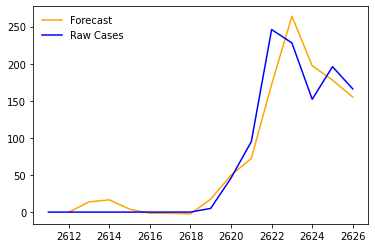

In [110]:
model = LinearRegression().fit(X=XandTarget[covariates2predictCases] , y= XandTarget[target])
predictions = model.predict(XandTarget[covariates2predictCases])

fig,ax = plt.subplots()

ax.plot(XandTarget.modelweek, predictions,color='orange', label ='Forecast')
ax.plot(specificRegion.modelweek, specificRegion.dohweb__numnewpos,color='blue', label = 'Raw Cases')

# what am i missing in my plot?

ax.legend(frameon=False)

# Step 3: Forecast on retrospective data

We have a nice looking model that can make predictions for a single region. 
Let's train our model and make predictions as if we went back to future. 
We'll start in epidemic week 2020W01. We will train our model on data only available at that time, make predictions, and then advance to the next week (2020W02). 

### Package up your model
#### 1.  Your model shoud assign probabilities to new cases from 0 to 1,000 by 5. 

In [138]:
import scipy

regiondata = specificRegion

# Make prediction 1 week into the future
# Covariates needed for model
covariates2predictCases = ['cdcili__ili','covidtracker__numnewpos']
target = ['dohweb__numnewpos']

# Setup "X" data
Xvariables = specificRegion[['modelweek']+covariates2predictCases]
Xvariables['modelweekPlusOne'] = Xvariables.modelweek+1
Xvariables = Xvariables.drop(columns=['modelweek'])

# extract target variable 
targetVariable = specificRegion[ ['modelweek']+target]

# build data for model
XandTarget = Xvariables.merge(targetVariable, left_on=['modelweekPlusOne'], right_on = ['modelweek'])

#build model
model      = LinearRegression().fit(X=XandTarget[covariates2predictCases] , y= XandTarget[target])
beta       = model.coef_[0]
intercept  = model.intercept_

# make probabilistic predictions
mostRecentDataOnXandTarget = XandTarget.iloc[-1]

# Linear regression assumes a normal distribution
def computeSigma(XandTarget,target):
    predictions = model.predict(XandTarget[covariates2predictCases])
    target = XandTarget[target].values
    
    return sum((target - predictions)**2) / len(predictions)-1

variance = computeSigma(XandTarget,target)
mean = intercept + beta[0]*mostRecentDataOnXandTarget.cdcili__ili + beta[1]*mostRecentDataOnXandTarget.covidtracker__numnewpos

# assign probabilities to the number of new cases
predictiveDistCDF = scipy.stats.norm(loc=mean, scale=variance).cdf

forecastData = {'numnewcases_leftbin':[],'numnewcases_rightbin':[],'prob':[]}

stepsize=5
for numOfNewCases in np.arange(0,10**3,stepsize):
    probability = predictiveDistCDF(numOfNewCases+stepsize) - predictiveDistCDF(numOfNewCases)

    forecastData['numnewcases_leftbin'].append(numOfNewCases)
    forecastData['numnewcases_rightbin'].append(numOfNewCases+stepsize)
    forecastData['prob'].append(probability)
forecastData = pd.DataFrame(forecastData)

# i restricted the range of values to forecast.
forecastData['prob'] = forecastData.prob/forecastData.prob.sum()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


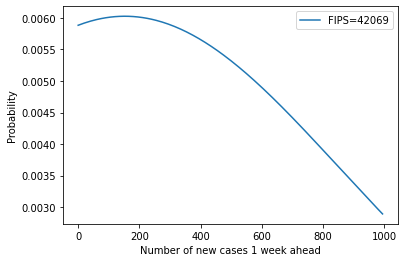

In [141]:
fig,ax = plt.subplots()

ax.plot(forecastData.numnewcases_leftbin, forecastData.prob, label = "FIPS=42069")

ax.set_xlabel("Number of new cases 1 week ahead")
ax.set_ylabel("Probability")

ax.legend()
plt.show()

#### 2. My model inputs region data and outputs a data frame of probabilities. Time to package this!

In [ ]:
def makeForecast(regiondata)
    import scipy

    # Make prediction 1 week into the future
    # Covariates needed for model
    covariates2predictCases = ['cdcili__ili','covidtracker__numnewpos']
    target = ['dohweb__numnewpos']

    # Setup "X" data
    Xvariables = specificRegion[['modelweek']+covariates2predictCases]
    Xvariables['modelweekPlusOne'] = Xvariables.modelweek+1
    Xvariables = Xvariables.drop(columns=['modelweek'])

    # extract target variable 
    targetVariable = specificRegion[ ['modelweek']+target]

    # build data for model
    XandTarget = Xvariables.merge(targetVariable, left_on=['modelweekPlusOne'], right_on = ['modelweek'])

    #build model
    model      = LinearRegression().fit(X=XandTarget[covariates2predictCases] , y= XandTarget[target])
    beta       = model.coef_[0]
    intercept  = model.intercept_

    # make probabilistic predictions
    mostRecentDataOnXandTarget = XandTarget.iloc[-1]

    # Linear regression assumes a normal distribution
    def computeSigma(XandTarget,target):
        predictions = model.predict(XandTarget[covariates2predictCases])
        target = XandTarget[target].values

        return sum((target - predictions)**2) / len(predictions)-1

    variance = computeSigma(XandTarget,target)
    mean = intercept + beta[0]*mostRecentDataOnXandTarget.cdcili__ili + beta[1]*mostRecentDataOnXandTarget.covidtracker__numnewpos

    # assign probabilities to the number of new cases
    predictiveDistCDF = scipy.stats.norm(loc=mean, scale=variance).cdf

    forecastData = {'numnewcases_leftbin':[],'numnewcases_rightbin':[],'prob':[]}

    stepsize=5
    for numOfNewCases in np.arange(0,10**3,stepsize):
        probability = predictiveDistCDF(numOfNewCases+stepsize) - predictiveDistCDF(numOfNewCases)

        forecastData['numnewcases_leftbin'].append(numOfNewCases)
        forecastData['numnewcases_rightbin'].append(numOfNewCases+stepsize)
        forecastData['prob'].append(probability)
    forecastData = pd.DataFrame(forecastData)

    # i restricted the range of values to forecast between 0 and 1000.
    forecastData['prob'] = forecastData.prob/forecastData.prob.sum()

    return forecastData

In [ ]:
# copy this section and rename sciencedogsmodel to your team and model name
class sciencedogsmodel(object):
    
    # Copy this section 
    def __init__(self,trainingdata):
        self.trainingdata = trainingdata
    
    # Copy this function 
    def makeForecasts(self):
        forecastsForAllRegions = pd.DataFrame()
        for fip in self.trainingdata.fips:
            regiondata = self.trainingdata[self.trainingdata.fips==fip]
            
            forecastData = makeForecastForOneRegion(regiondata)
            
            forecastData['fips'] = fip
            
            forecastsForAllRegions = forecastsForAllRegions.append(forecastData)
        return forecastsForAllRegions
    
    # -------------------------------This is your model code------------------------
    def makeForecastForOneRegion(self,regiondata)
        import scipy

        # Make prediction 1 week into the future
        # Covariates needed for model
        covariates2predictCases = ['cdcili__ili','covidtracker__numnewpos']
        target = ['dohweb__numnewpos']

        # Setup "X" data
        Xvariables = specificRegion[['modelweek']+covariates2predictCases]
        Xvariables['modelweekPlusOne'] = Xvariables.modelweek+1
        Xvariables = Xvariables.drop(columns=['modelweek'])

        # extract target variable 
        targetVariable = specificRegion[ ['modelweek']+target]

        # build data for model
        XandTarget = Xvariables.merge(targetVariable, left_on=['modelweekPlusOne'], right_on = ['modelweek'])

        #build model
        model      = LinearRegression().fit(X=XandTarget[covariates2predictCases] , y= XandTarget[target])
        beta       = model.coef_[0]
        intercept  = model.intercept_

        # make probabilistic predictions
        mostRecentDataOnXandTarget = XandTarget.iloc[-1]

        # Linear regression assumes a normal distribution
        def computeSigma(XandTarget,target):
            predictions = model.predict(XandTarget[covariates2predictCases])
            target = XandTarget[target].values

            return sum((target - predictions)**2) / len(predictions)-1

        variance = computeSigma(XandTarget,target)
        mean = intercept + beta[0]*mostRecentDataOnXandTarget.cdcili__ili + beta[1]*mostRecentDataOnXandTarget.covidtracker__numnewpos

        # assign probabilities to the number of new cases
        predictiveDistCDF = scipy.stats.norm(loc=mean, scale=variance).cdf

        forecastData = {'numnewcases_leftbin':[],'numnewcases_rightbin':[],'prob':[]}

        stepsize=5
        for numOfNewCases in np.arange(0,10**3,stepsize):
            probability = predictiveDistCDF(numOfNewCases+stepsize) - predictiveDistCDF(numOfNewCases)

            forecastData['numnewcases_leftbin'].append(numOfNewCases)
            forecastData['numnewcases_rightbin'].append(numOfNewCases+stepsize)
            forecastData['prob'].append(probability)
        forecastData = pd.DataFrame(forecastData)

        # i restricted the range of values to forecast between 0 and 1000.
        forecastData['prob'] = forecastData.prob/forecastData.prob.sum()

        return forecastData  

 TO BE CONTINUED

In [106]:
import sys
sys.path.append('/Users/thomasmcandrew/science/syndromicSurv/data/')
from trainer import turnbacktime

back2thefuture = trainModelOverTime(specificRegion,)





NameError: name 'trainModelOverTime' is not defined

# Step 4: Forecast on current data

# Step 5: Build ensemble on out-of-sample forecasts

# Step 6: Produce Ensemble forecast for 1, 2, 3, and 4 weeks ahead